In [1]:
# Synthetic dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
import numpy as np
from collections import Counter
# Visualization
import matplotlib.pyplot as plt
# Model and performance
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
# Import the necessary libraries.
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
#!pip install pyod            # normal install
#!pip install --upgrade pyod  # or update if needed
from pyod.models.pca import PCA as PCA_PYOD
from pyod.models.kpca import KPCA as KPCA_PYOD
from scipy.io import loadmat
import os
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import f1_score

### Breast Cancer dataset

In [2]:
data = []
target = []
dimensionality = []
dataset = []

df = load_breast_cancer()
name = 'breast_cancer'

In [3]:
var = name+"_data"

var = pd.DataFrame(data=df, columns=df.feature_names)
var.columns = ['feature{}'.format(i) for i in range(0,var.shape[1])]

dataset = pd.DataFrame(df.data).assign(target=df.target)
print (dataset.shape,pd.DataFrame(df.target).nunique().tolist()[-1:])

(569, 31) [2]


In [4]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [5]:
Counter(dataset['target'])

Counter({0: 212, 1: 357})

In [6]:
dataset_reduced = dataset.drop(dataset[dataset['target'] == 0].sample(frac=0.20).index)

In [7]:
Counter(dataset_reduced['target'])

Counter({0: 170, 1: 357})

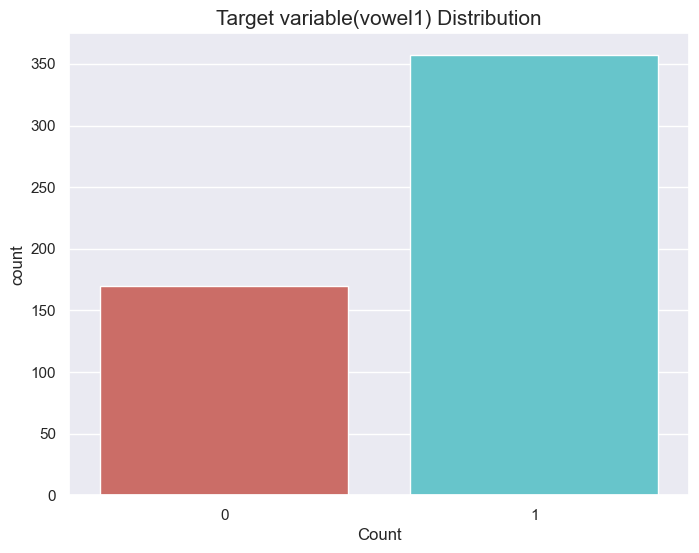

In [8]:
sns.set(rc = {'figure.figsize':(8,6)})
g1 = sns.countplot(x="target",data= dataset_reduced, palette="hls")                  
g1.set_title("Target variable(vowel1) Distribution", fontsize=15)
g1.set_xlabel("Vowel1")
g1.set_xlabel("Count")
plt.show()

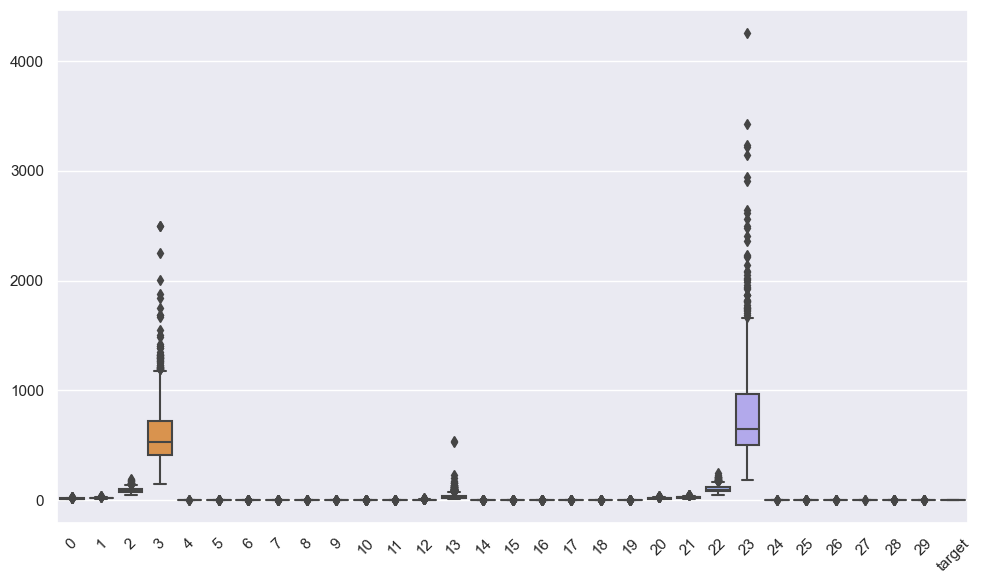

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
box = sns.boxplot(data=dataset_reduced) 
box.set_xticklabels(box.get_xticklabels(), rotation= 45) 
fig.subplots_adjust(bottom=0.2)
plt.tight_layout()

In [10]:
outliers = Counter(dataset_reduced['target'])[0]
inliers = Counter(dataset_reduced['target'])[1]

contamination = outliers/inliers 
contamination

0.47619047619047616

In [11]:
dataset_reduced[dataset_reduced.columns[:-1]]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,20.92,25.09,143.00,1347.0,0.10990,0.22360,0.31740,0.14740,0.2149,0.06879,...,24.290,29.41,179.10,1819.0,0.14070,0.41860,0.6599,0.2542,0.2929,0.09873
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [12]:
n_features = dataset_reduced.shape[1]     # number of features

X = dataset_reduced[dataset_reduced.columns[:-1]]
y = dataset_reduced['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

X_train_pd = pd.DataFrame(X_train)
X_train_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
283,16.24,18.77,108.80,805.1,0.10660,0.18020,0.194800,0.090520,0.1876,0.06684,...,18.550,25.09,126.90,1031.0,0.13650,0.47060,0.50260,0.17320,0.2770,0.10630
469,11.62,18.18,76.38,408.8,0.11750,0.14830,0.102000,0.055640,0.1957,0.07255,...,13.360,25.40,88.14,528.1,0.17800,0.28780,0.31860,0.14160,0.2660,0.09270
309,13.05,13.84,82.71,530.6,0.08352,0.03735,0.004559,0.008829,0.1453,0.05518,...,14.730,17.40,93.96,672.4,0.10160,0.05847,0.01824,0.03532,0.2107,0.06580
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.000000,0.000000,0.1587,0.05884,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.00000,0.00000,0.2871,0.07039
501,13.82,24.49,92.33,595.9,0.11620,0.16810,0.135700,0.067590,0.2275,0.07237,...,16.010,32.94,106.00,788.0,0.17940,0.39660,0.33810,0.15210,0.3651,0.11830


## PCA

In [174]:
#implementation PCA
pca = PCA_PYOD(n_components=2, contamination=contamination) 
pca.fit(X_train)


PCA(contamination=0.47619047619047616, copy=True, iterated_power='auto',
  n_components=2, n_selected_components=None, random_state=None,
  standardization=True, svd_solver='auto', tol=0.0, weighted=True,
  whiten=False)

In [175]:
# PCA
# get the prediction labels and outlier scores of the training data
y_train_pred_pca = pca.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores_pca = pca.decision_scores_  # .decision_scores_ yields the raw outlier scores for the training data

# get the prediction labels and outlier scores of the test data
y_test_scores_pca = pca.decision_function(X_test)
y_test_pred_pca = pca.predict(X_test)


In [176]:
pca.get_params()

{'contamination': 0.47619047619047616,
 'copy': True,
 'iterated_power': 'auto',
 'n_components': 2,
 'n_selected_components': None,
 'random_state': None,
 'standardization': True,
 'svd_solver': 'auto',
 'tol': 0.0,
 'weighted': True,
 'whiten': False}

In [177]:
[pca.explained_variance_,
pca.explained_variance_ratio_]

[array([13.43449092,  5.79909637]), array([0.44659947, 0.19277793])]

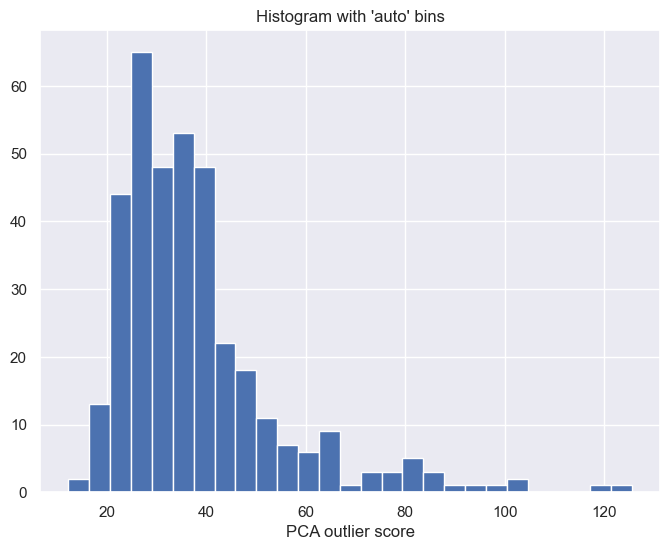

In [178]:
# get the prediction on the test data
y_test_pred_pca = pca.predict(X_test)  # outlier labels (0 or 1)
y_test_scores_pca = pca.decision_function(X_test)  # outlier scores

plt.hist(y_train_scores_pca, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.xlabel('PCA outlier score')
plt.show()

## Kernel PCA

In [179]:
# KPCA
kpca = KPCA_PYOD(n_components=2, kernel='rbf', gamma=0.15, contamination=contamination)
kpca.fit(X_train)

KPCA(alpha=None, coef0=None, contamination=0.47619047619047616, copy_X=None,
   degree=None, eigen_solver=None, gamma=None, kernel=None,
   kernel_params=None, max_iter=None, n_components=2, n_jobs=None,
   n_selected_components=None,
   random_state=RandomState(MT19937) at 0x251D19AF740,
   remove_zero_eig=None, sampling=False, subset_size=20, tol=None)

In [180]:
# KPCA
# get the prediction labels and outlier scores of the training data
y_train_pred_kpca = kpca.labels_
y_train_scores_kpca = kpca.decision_scores_

# get the prediction labels and outlier scores of the test data
y_test_scores_kpca = kpca.decision_function(X_test)
y_test_pred_kpca = kpca.predict(X_test)

In [181]:
kpca.get_params()

{'alpha': None,
 'coef0': None,
 'contamination': 0.47619047619047616,
 'copy_X': None,
 'degree': None,
 'eigen_solver': None,
 'gamma': None,
 'kernel': None,
 'kernel_params': None,
 'max_iter': None,
 'n_components': 2,
 'n_jobs': None,
 'n_selected_components': None,
 'random_state': RandomState(MT19937) at 0x251D19AF740,
 'remove_zero_eig': None,
 'sampling': False,
 'subset_size': 20,
 'tol': None}

In [182]:
# get the prediction on the test data
y_test_pred_kpca = kpca.predict(X_test)  # outlier labels (0 or 1)
y_test_scores_kpca = kpca.decision_function(X_test)  # outlier scores

MemoryError: Unable to allocate 1.22 TiB for an array with shape (167433395041,) and data type float64

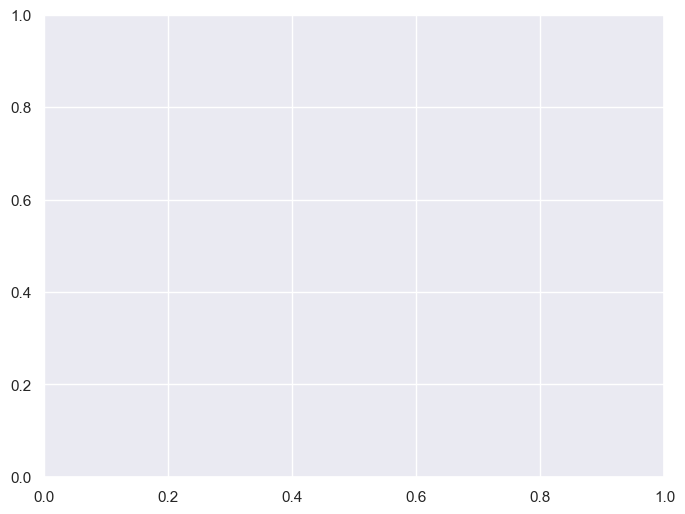

In [183]:
plt.hist(y_train_scores_kpca, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.xlabel('KPCA outlier score')
plt.show()

### Test other Kernels

In [ ]:
# Define a list of kernel functions and parameters to try
"""kernels = ['linear', 'poly', 'rbf', 'sigmoid']
gammas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]"""

In [ ]:
"""# Perform kernelPCA
# Initialize a subplot grid to plot the results
fig, axs = plt.subplots(len(kernels), len(gammas), figsize=(15, 15), constrained_layout=True)

# Loop over the kernels and gammas and perform KPCA
for i, kernel in enumerate(kernels):
    for j, gamma in enumerate(gammas):
        # Initialize the KPCA transformer and fit the data
        kpca = KernelPCA(n_components=2, kernel=kernel, gamma=gamma)
        X_kpca = kpca.fit_transform(X_train)

        # Plot the results
        axs[i, j].scatter(X_kpca[:, 0], X_kpca[:, 1], c=y_train, cmap='viridis', alpha=0.8)
        axs[i, j].set_title(f'{kernel} kernel, gamma={gamma}')

plt.show()"""

## Summary PCA and Kernel PCA

In [184]:
threshold_pca = pca.threshold_
threshold_kpca = kpca.threshold_

print("The threshold of the PCA method for the defined comtanimation rate:" , threshold_pca)
print("The threshold of the KPCA method for the defined comtanimation rate:" , threshold_kpca)

The threshold of the PCA method for the defined comtanimation rate: 34.95424953099283
The threshold of the KPCA method for the defined comtanimation rate: 0.9972542594994723


In [185]:
def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

In [186]:
descriptive_stat_threshold(X_train,y_train_scores_pca, threshold_pca)

,Group,Count,Count %,0,1,2,3,4,5,6,...,21,22,23,24,25,26,27,28,29,Anomaly_Score
0,Normal,193,52.445652,12.87,18.20,83.23,518.77,0.1,0.09,0.06,...,24.47,95.05,655.91,0.13,0.23,0.22,0.10,0.29,0.08,27.08
1,Outlier,175,47.554348,14.61,19.75,95.58,719.65,0.1,0.12,0.11,...,25.93,112.40,990.76,0.13,0.28,0.31,0.12,0.29,0.09,49.64


In [187]:
descriptive_stat_threshold(X_train,y_train_scores_kpca, threshold_kpca)

,Group,Count,Count %,0,1,2,3,4,5,6,...,21,22,23,24,25,26,27,28,29,Anomaly_Score
0,Normal,151,41.032609,11.90,17.25,76.44,440.99,0.09,0.08,0.05,...,23.14,85.68,540.65,0.13,0.19,0.18,0.08,0.28,0.08,0.98
1,Outlier,217,58.967391,14.95,20.11,97.91,734.89,0.10,0.12,0.11,...,26.58,115.57,1006.16,0.13,0.29,0.32,0.13,0.29,0.09,1.00


In [188]:
Actual_pred_pca = pd.DataFrame({'Actual': y_test, 'Anomaly_Score': y_test_scores_pca})
Actual_pred_pca['Pred'] = np.where(Actual_pred_pca['Anomaly_Score']< threshold_pca,0,1)
pd.crosstab(Actual_pred_pca['Actual'],Actual_pred_pca['Pred'])

Pred,0,1
Actual,,
0,18,33
1,83,25


In [189]:
Actual_pred_kpca = pd.DataFrame({'Actual': y_test, 'Anomaly_Score': y_test_scores_kpca})
Actual_pred_kpca['Pred'] = np.where(Actual_pred_kpca['Anomaly_Score']< threshold_kpca,0,1)
pd.crosstab(Actual_pred_kpca['Actual'],Actual_pred_kpca['Pred'])

Pred,1
Actual,
0,51
1,108


In [190]:
# fit PCA on training data
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# create a scatter plot of the projected data
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


C:\Users\Gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


ValueError: could not convert string to float: 'Outlier'

In [191]:
# fit KernelPCA on training data
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.01)
X_train_kpca = kpca.fit_transform(X_train)

# create a scatter plot of the projected data
plt.scatter(X_train_kpca[:, 0], X_train_kpca[:, 1], c=y_train, cmap='viridis')
plt.xlabel('Kernel Principal Component 1')
plt.ylabel('Kernel Principal Component 2')
plt.show()

C:\Users\Gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


ValueError: could not convert string to float: 'Outlier'

## SVM

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(dataset)

C:\Users\Gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Gokul\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [15]:
# X = dataset[dataset.columns[:-1]]
X = normalized_data[:,:-1]
y = dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

X_train_pd = pd.DataFrame(X_train)
X_train_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.219556,0.286439,0.225209,0.112534,0.585628,0.395436,0.238988,0.276541,0.453030,0.475779,...,0.193170,0.356610,0.187908,0.084275,0.705474,0.252748,0.254473,0.486598,0.215849,0.247016
1,0.199678,0.664863,0.185751,0.102863,0.197346,0.049690,0.000000,0.000000,0.000000,0.106571,...,0.141942,0.700426,0.123413,0.062525,0.141980,0.026826,0.000000,0.000000,0.000197,0.026302
2,0.169861,0.291173,0.159146,0.083733,0.259908,0.077419,0.046696,0.055219,0.662626,0.162595,...,0.107079,0.300906,0.094327,0.044509,0.176781,0.036994,0.031837,0.076357,0.223536,0.080808
3,0.273510,0.308759,0.263147,0.149777,0.398393,0.184467,0.062980,0.088519,0.353030,0.250000,...,0.207044,0.372335,0.186314,0.096957,0.387176,0.151944,0.100240,0.285636,0.232407,0.113735
4,0.203938,0.112614,0.196531,0.103712,0.412657,0.173916,0.076500,0.136928,0.358081,0.268324,...,0.156172,0.110874,0.138752,0.066924,0.426798,0.119733,0.101837,0.300687,0.230239,0.165158


In [16]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([148, 250], dtype=int64))

### rbf kernal

In [147]:
# Train the one class support vector machine (SVM) model
one_class_svm = OneClassSVM(nu=0.4, kernel = 'rbf', gamma = 'auto').fit(X_train)

In [148]:
# Check the model performance
prediction = one_class_svm.predict(X_test)
prediction = [0 if i==-1 else 1 for i in prediction]

In [149]:
print("The accuracy score predicted is {}".format(f1_score(y_test, prediction)))

The accuracy score predicted is 0.711111111111111


In [150]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.49      0.41      0.44        64
           1       0.68      0.75      0.71       107

    accuracy                           0.62       171
   macro avg       0.58      0.58      0.58       171
weighted avg       0.61      0.62      0.61       171



In [151]:
ds1_f1 = []

In [152]:
ds1_f1.append(f1_score(y_test, prediction))

### poly kernal

In [153]:
# Train the one class support vector machine (SVM) model
one_class_svm = OneClassSVM(nu=0.4, kernel = 'poly', gamma = 'auto').fit(X_train)

In [154]:
# Check the model performance
prediction = one_class_svm.predict(X_test)
prediction = [0 if i==-1 else 1 for i in prediction]

In [155]:
print("The accuracy score predicted is {}".format(f1_score(y_test, prediction)))

The accuracy score predicted is 0.43317972350230416


In [156]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.02      0.02      0.02        64
           1       0.43      0.44      0.43       107

    accuracy                           0.28       171
   macro avg       0.22      0.23      0.22       171
weighted avg       0.27      0.28      0.28       171



In [157]:
ds1_f1.append(f1_score(y_test, prediction))

### linear kernal 

In [158]:
# Train the one class support vector machine (SVM) model
one_class_svm = OneClassSVM(nu=0.4, kernel = 'linear', gamma = 'auto').fit(X_train)

In [159]:
# Check the model performance
prediction = one_class_svm.predict(X_test)
prediction = [0 if i==-1 else 1 for i in prediction]

In [160]:
print("The accuracy score predicted is {}".format(f1_score(y_test, prediction)))

The accuracy score predicted is 0.49557522123893805


In [161]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.02      0.02      0.02        64
           1       0.47      0.52      0.50       107

    accuracy                           0.33       171
   macro avg       0.24      0.27      0.26       171
weighted avg       0.30      0.33      0.32       171



In [162]:
ds1_f1.append(f1_score(y_test, prediction))

### sigmoid kernal

In [163]:
# Train the one class support vector machine (SVM) model
one_class_svm = OneClassSVM(nu=0.4, kernel = 'sigmoid', gamma = 'auto').fit(X_train)

In [164]:
# Check the model performance
prediction = one_class_svm.predict(X_test)
prediction = [0 if i==-1 else 1 for i in prediction]

In [165]:
print("The accuracy score predicted is {}".format(f1_score(y_test, prediction)))

The accuracy score predicted is 0.49557522123893805


In [166]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.02      0.02      0.02        64
           1       0.47      0.52      0.50       107

    accuracy                           0.33       171
   macro avg       0.24      0.27      0.26       171
weighted avg       0.30      0.33      0.32       171



In [167]:
ds1_f1.append(f1_score(y_test, prediction))

In [168]:
ds1_f1

[0.711111111111111,
 0.43317972350230416,
 0.49557522123893805,
 0.49557522123893805]

In [169]:
kernels = ['rbf','linear','poly','sigmoid']

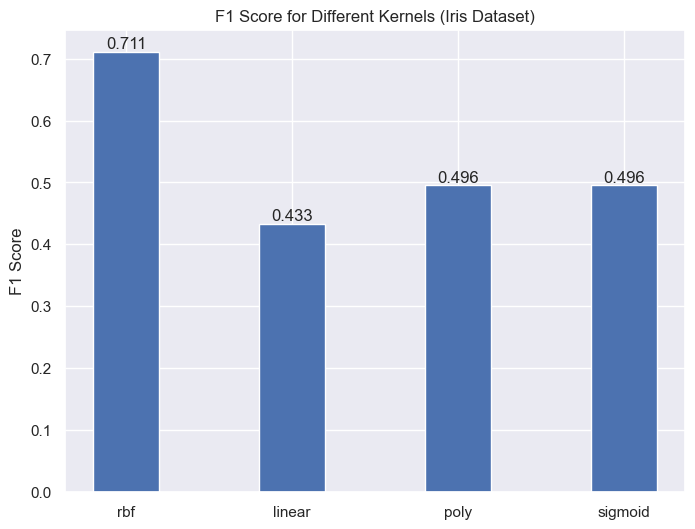

In [170]:
# Set the width of the bars
bar_width = 0.4

# Create a list of x positions for the bars
x_pos = range(len(kernels))

# Create the bar plot
plt.bar(x_pos, ds1_f1, width=bar_width)

# Set the x-axis labels
plt.xticks(x_pos, kernels)

# Set the y-axis label
plt.ylabel('F1 Score')

# Set the title of the graph
plt.title('F1 Score for Different Kernels (Iris Dataset)')

# Add the rounded values on top of each bar
for i, value in enumerate(ds1_f1):
    rounded_value = round(value, 3)  # Round off to three decimal points
    plt.text(i, value, str(rounded_value), ha='center', va='bottom')

# Show the plot
plt.show()
